# импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.cluster import KMeans
from sklearn import linear_model, model_selection, metrics
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.random_projection import SparseRandomProjection
from itertools import product
import warnings
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")
import folium
from pandas.tseries.holiday import USFederalHolidayCalendar
import csv
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.spatial import distance


drive.mount('/final_project/')

%cd "/final_project/MyDrive/final_project"

# функции

In [4]:
def preproccessing_and_aggregation_data(file, REGIONS, NY_LOCATION):


  data = pd.read_csv(file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

  # удаляем поездки с нулевой длительностью
  data = data[data['tpep_dropoff_datetime'] != data['tpep_pickup_datetime']]

  # удаляем поездки с нулевым количеством пассажиров
  data = data[data.passenger_count != 0]

  # удаляем поездки с нулевым расстояние поездки
  data = data[data.trip_distance != 0]

  # удаляем поездки с координатами не в Нью-Йорке
  data = data[((data.pickup_longitude > NY_LOCATION[0]) & (data.pickup_longitude < NY_LOCATION[1])) & ((data.pickup_latitude > NY_LOCATION[2]) & (data.pickup_latitude < NY_LOCATION[3]))]

  # добавляем столбец с часом
  data['tpep_pickup_hour'] = data.tpep_pickup_datetime.map(lambda x: x.floor(freq='h'))

  # определяем номер региона для каждого вызова такси (скопировал из обсуждений)
  statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                  data['pickup_latitude'].values, 
                                  data['VendorID'], 
                                  statistic='count', 
                                  bins=[REGIONS['west'].append(REGIONS['east']).unique(), 
                                        REGIONS['south'].append(REGIONS['north']).unique()], 
                                  expand_binnumbers=True)
                                    
  data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

  # создаем сводную таблицу по сумме количества поездок, в которой в колонках номера регионов, а в индексе час начала поездок 
  agg_table = pd.pivot_table(data, values='VendorID', index='tpep_pickup_hour', columns='region', aggfunc='count')
  data = None
  return agg_table

def load_data(AGG_FILES, date_before, date_after):
  data = pd.concat([pd.read_csv(file, sep=';', parse_dates=['tpep_pickup_hour']) for file in AGG_FILES])
  data.set_index('tpep_pickup_hour', inplace=True)
  data = data[COLUMNS_FROM_2_WEEK]
  data = data[date_after <= data.index]
  data = data[data.index <= date_before]
  data.fillna(value=0, inplace=True)
  return data



def get_regions_from_second_week():
  data = pd.read_csv('agg_yellow_tripdata_2016-05.csv', sep=';')
  data.set_index('tpep_pickup_hour', inplace=True)
  cols = (data.sum(axis=0) / len(data)) >= 5
  cols = cols.reset_index()
  return cols[cols[0] == True]['index'].values

def my_style_function(x):
    color = ''
    if x['properties']['cluster'] == 0:
        color = 'green'
    elif x['properties']['cluster'] == 1:
        color = 'orange'
    elif x['properties']['cluster'] == 2:
        color = 'blue'
    elif x['properties']['cluster'] == 3:
        color = 'green'
    elif x['properties']['cluster'] == 4:
        color = 'yellow'
    return {'fillColor': color, 'stroke': True, 'weight': 0.5, 'fillOpacity':0.7}


def add_features(data, k, holidays):
    data['const'] = 1
    data['lin'] = np.arange(1, data.shape[0]+1)
    data['is_holiday'] = [x in holidays for x in data.index.floor('d')]
    features_columns = ['const', 'lin', 'is_holiday']
    features_columns += month_features(data)
    features_columns += weekday_features(data)
    features_columns += hour_features(data)
    for i in range(1, k+1):
        week_sin_col = f'week_sin_{i}'
        week_cos_col = f'week_cos_{i}'
        data[week_sin_col] = np.sin(np.array(data['lin'] * 2 * np.pi * i / 168))
        data[week_cos_col] = np.cos(np.array(data['lin'] * 2 * np.pi * i / 168))
        features_columns += [week_sin_col, week_cos_col]

    data.replace(True, 1, inplace=True)
    data.replace(False, 0, inplace=True)
    return features_columns

def get_reg_pred(data, features_columns):
    train_data = np.array(data[features_columns])
    train_labels = np.array(data['trips'])
    
    model = ElasticNet(random_state=42)
    model.fit(train_data, train_labels)
    
    preds = model.predict(data[features_columns])
    
    data['reg_pred'] = preds
    data['reg_resid'] = data['trips'] - preds
    
    return preds

def month_features(data):
  features_columns = []
  for x in range(1, 13):
    col_name = f'month{x}'
    data[col_name] = [data.index.month == x][0]
    features_columns.append(col_name)
  
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns

def hour_features(data):
  features_columns = []
  for x in range(0, 24):
    col_name = f'hour{x}'
    data[col_name] = [data.index.hour == x][0]
    features_columns.append(col_name)
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns

def weekday_features(data):
  features_columns = []
  for x in range(0, 7):
    col_name = f'weekday{x}'
    data[col_name] = [data.index.weekday == x][0]
    features_columns.append(col_name)
  data.replace(True, 1, inplace=True)
  data.replace(False, 0, inplace=True)
  return features_columns


def load_data_cluster(cluster=0, 
                      date_after=datetime.datetime(2015, 12, 1, 0), 
                      date_before=datetime.datetime(2016, 5, 31, 23)) :
  data_cluster = pd.DataFrame(load_data(AGG_FILES, date_before, date_after)[str(closest_regions[cluster][0])])
  data_cluster.columns = ['trips']
  features_columns = add_features(data_cluster, K, HOLIDAYS)
  reg_pred = get_reg_pred(data_cluster, features_columns)
  return data_cluster

def plot_linear_reg(data_cluster):
  plt.figure(figsize=(20, 5))
  data_cluster['trips'].rolling(24).mean().plot(legend=True, title=f'Фактическое количество + прогноз линейной регрессии при K={K}')
  data_cluster['reg_pred'].rolling(24).mean().plot(legend=True)
  plt.show()

  plt.figure(figsize=(20, 5))
  data_cluster.reg_resid.rolling(24).mean().plot(title='Остатки', legend=True)
  plt.show()

def plot_decompose(data_cluster, reg_resid):
  result = sm.tsa.seasonal_decompose(data_cluster[reg_resid].dropna(), freq=24)
  fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25,10))
  axes[0].plot(result.observed)
  axes[0].set(ylabel='Observed')
  axes[1].plot(result.trend)
  axes[1].set(ylabel='trend')
  axes[2].plot(result.seasonal)
  axes[2].set(ylabel='seasonal')
  axes[3].plot(result.resid)  
  axes[3].set(ylabel='resid') 
  print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_cluster.trips)[1])
  plt.show()

def plot_acf_pacf(data_cluster):
  print('Строим полную и частичную автокорреляцию')
  plt.figure(figsize=(20,10))
  ax = plt.subplot(211)
  sm.graphics.tsa.plot_acf(data_cluster.reg_resid_diff.dropna().values.squeeze(), lags=168, ax=ax)
  ax = plt.subplot(212)
  sm.graphics.tsa.plot_pacf(data_cluster.reg_resid_diff.dropna().values.squeeze(), lags=168, ax=ax)
  plt.show()



def select_best_arima(data, params, d, D):
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  i=0
  for param in params:
      print(i, '-', param, '...', datetime.datetime.now(), '...')
      i+=1
      #try except нужен, потому что на некоторых наборах параметров модель не обучается
      try:
          model=sm.tsa.statespace.SARIMAX(data.reg_resid, order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=14)
      
      #выводим параметры, на которых модель не обучается и переходим к следующему набору
      except ValueError:
          print('wrong parameters:', param)
          continue
      aic = model.aic
      #сохраняем лучшую модель, aic, параметры
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])
      
  warnings.filterwarnings('default')
  return (best_model, results)

### 1. 
Для каждой из шести задач прогнозирования сформируйте выборки.

Сформируем таблицу по аналогии с прошлыми неделями

In [12]:
REGIONS = pd.read_csv('regions.csv', sep=';')
NY_LOCATION = [-74.25559, -73.70001, 40.49612, 40.91553]
COLUMNS_FROM_2_WEEK = get_regions_from_second_week()
HOLIDAYS = USFederalHolidayCalendar().holidays(start=datetime.datetime(2015, 1, 1), end=datetime.datetime(2016, 6, 1))

FILES = ['yellow_tripdata_2015-12.csv',
         'yellow_tripdata_2016-01.csv',
         'yellow_tripdata_2016-02.csv',
         'yellow_tripdata_2016-03.csv',
         'yellow_tripdata_2016-04.csv',
         'yellow_tripdata_2016-05.csv',
         'yellow_tripdata_2016-06.csv']

AGG_FILES =  ['agg_yellow_tripdata_2015-01.csv',
              'agg_yellow_tripdata_2015-02.csv',
              'agg_yellow_tripdata_2015-03.csv',
              'agg_yellow_tripdata_2015-04.csv',
              'agg_yellow_tripdata_2015-05.csv',
              'agg_yellow_tripdata_2015-06.csv',
              'agg_yellow_tripdata_2015-07.csv',
              'agg_yellow_tripdata_2015-08.csv',
              'agg_yellow_tripdata_2015-09.csv',
              'agg_yellow_tripdata_2015-10.csv',
              'agg_yellow_tripdata_2015-11.csv',
              'agg_yellow_tripdata_2015-12.csv',
              'agg_yellow_tripdata_2016-01.csv',
              'agg_yellow_tripdata_2016-02.csv',
              'agg_yellow_tripdata_2016-03.csv',
              'agg_yellow_tripdata_2016-04.csv',
              'agg_yellow_tripdata_2016-05.csv',
              'agg_yellow_tripdata_2016-06.csv']     

"""
#преобразовываем выгрузку в сводную таблицу
for file in FILES:
  data = preproccessing_and_aggregation_data(file, REGIONS, NY_LOCATION)
  data.to_csv('agg_'+file, sep=';')
"""

data = load_data(AGG_FILES, date_after=datetime.datetime(2015, 1, 1), date_before=datetime.datetime(2016, 6, 30, 23))
data.reset_index(inplace=True)
data.head()

,tpep_pickup_hour,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,1132,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1227,1228,1229,1230,1231,1232,1233,1234,1235,1272,...,1376,1377,1378,1380,1382,1383,1384,1385,1386,1387,1388,1389,1390,1426,1431,1434,1435,1436,1437,1438,1439,1441,1442,1480,1482,1483,1530,1532,1533,1580,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,42.0,17.0,61.0,53.0,27.0,29.0,639.0,711.0,857.0,1023.0,711.0,747.0,514.0,20.0,30.0,55.0,43.0,45.0,12.0,469.0,829.0,1116.0,1550.0,1125.0,244.0,776.0,560.0,261.0,67.0,...,67.0,54.0,35.0,31.0,23.0,319.0,981.0,342.0,59.0,102.0,65.0,43.0,56.0,53.0,36.0,7.0,28.0,72.0,75.0,42.0,30.0,18.0,32.0,23.0,47.0,31.0,20.0,31.0,31.0,7.0,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
1,2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,55.0,36.0,102.0,91.0,31.0,48.0,604.0,530.0,611.0,669.0,842.0,736.0,354.0,23.0,95.0,108.0,94.0,86.0,24.0,568.0,901.0,1124.0,1587.0,922.0,336.0,651.0,743.0,297.0,123.0,...,148.0,138.0,108.0,59.0,24.0,401.0,1266.0,449.0,94.0,141.0,118.0,71.0,130.0,79.0,63.0,14.0,37.0,114.0,131.0,61.0,66.0,42.0,48.0,35.0,104.0,70.0,73.0,98.0,139.0,21.0,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0
2,2015-01-01 02:00:00,99.0,179.0,39.0,127.0,372.0,409.0,391.0,443.0,475.0,180.0,22.0,43.0,116.0,109.0,23.0,56.0,621.0,434.0,464.0,501.0,751.0,651.0,393.0,20.0,112.0,112.0,90.0,77.0,35.0,544.0,792.0,970.0,1293.0,767.0,407.0,633.0,593.0,262.0,125.0,...,167.0,148.0,116.0,59.0,16.0,289.0,1042.0,331.0,101.0,140.0,141.0,81.0,91.0,85.0,75.0,4.0,38.0,81.0,124.0,59.0,43.0,55.0,67.0,55.0,146.0,70.0,82.0,129.0,176.0,43.0,48.0,0.0,2.0,1.0,2.0,0.0,0.0,5.0,0.0,1.0
3,2015-01-01 03:00:00,80.0,116.0,19.0,79.0,325.0,461.0,315.0,415.0,335.0,159.0,8.0,35.0,85.0,53.0,19.0,72.0,809.0,428.0,475.0,549.0,610.0,657.0,458.0,14.0,55.0,96.0,71.0,76.0,38.0,599.0,885.0,1110.0,1400.0,774.0,733.0,721.0,339.0,125.0,82.0,...,174.0,161.0,111.0,47.0,9.0,159.0,639.0,167.0,60.0,104.0,98.0,63.0,97.0,96.0,74.0,2.0,22.0,80.0,87.0,57.0,66.0,46.0,54.0,42.0,126.0,44.0,56.0,126.0,153.0,30.0,34.0,0.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0
4,2015-01-01 04:00:00,25.0,54.0,15.0,69.0,172.0,319.0,274.0,364.0,371.0,132.0,3.0,9.0,47.0,32.0,5.0,51.0,661.0,455.0,417.0,429.0,353.0,631.0,316.0,4.0,31.0,37.0,50.0,53.0,14.0,459.0,774.0,763.0,758.0,548.0,678.0,422.0,155.0,96.0,43.0,...,153.0,93.0,79.0,21.0,5.0,116.0,391.0,115.0,33.0,69.0,60.0,49.0,77.0,66.0,43.0,2.0,12.0,60.0,69.0,35.0,39.0,51.0,23.0,47.0,78.0,53.0,48.0,96.0,120.0,23.0,38.0,0.0,5.0,2.0,3.0,4.0,0.0,3.0,0.0,16.0


Загружим таблицу с кластерами с прошлой недели



In [13]:
regions_with_cluster = pd.read_csv('regions_with_cluster.csv') # файл с прошлой недели
regions_with_cluster.head(2)

,region,west,east,south,north,cluster
0,1075,-74.022246,-74.011135,40.697437,40.705825,0
1,1076,-74.022246,-74.011135,40.705825,40.714213,1


Сформируем таблиц с признаками

In [14]:
%%time
# создаем пустую таблицу
data_for_reg = pd.DataFrame(columns=['tpep_pickup_hour'])

for cell_num in data.columns[1:]: # цикл по 102 ячейкам/регионам
  # создаем временный dataframe
  data_temp = data[['tpep_pickup_hour', cell_num]]

  # изменяем название колонок
  data_temp.columns = ['tpep_pickup_hour', 'trips']

  # добавляем номер ячейки/региона в отдельный столбец в качестве признака
  data_temp['region_num'] = cell_num
  #data_temp[f'cell_num_{cell_num}'] = 1

  # добавляем столбцы с количеством вызовов такси на 1-6 часов вперед - целевая переменная
  for i in range(1, 7):
    data_temp[f'Y+{i}'] = data_temp.trips.shift(-i)
  
  # добавляем столбцы с количеством вызовов такси на 1-23 часов назад
  for i in range(1, 24):
    data_temp[f'trips-{i}'] = data_temp.trips.shift(i)

  # добавляем столбцы с количеством вызовов такси на 24, 48, 168 часов назад
  data_temp['trips-24'] = data_temp.trips.shift(24)
  data_temp['trips-48'] = data_temp.trips.shift(48)
  data_temp['trips-168'] = data_temp.trips.shift(168)

  # добавляем константы 
  data_temp['const'] = 1
  data_temp['lin'] = np.arange(1, data_temp.shape[0]+1)
  
  k=50
  # добавляем синусы и косинусы
  for i in range(1, k+1):
        week_sin_col = f'week_sin_{i}'
        week_cos_col = f'week_cos_{i}'
        data_temp[week_sin_col] = np.sin(np.array(data_temp['lin'] * 2 * np.pi * i / 168))
        data_temp[week_cos_col] = np.cos(np.array(data_temp['lin'] * 2 * np.pi * i / 168))
  
  # добавляем признак выходного дня
  data_temp['is_holiday'] = [x.floor('d') in HOLIDAYS for x in data_temp.tpep_pickup_hour]
  
  data_temp.set_index('tpep_pickup_hour', inplace=True)
  # Добавляем признак месяца
  for x in range(1, 13):
    col_name = f'month_{x}'
    data_temp[col_name] = [data_temp.index.month == x][0]

  # Добавляем признак года
  for x in [2015, 2016]:
    col_name = f'year_{x}'
    data_temp[col_name] = [data_temp.index.year == x][0]

  # добавляем признак часа
  for x in range(0, 24):
    col_name = f'hour_{x}'
    data_temp[col_name] = [data_temp.index.hour == x][0]

  # добавляем признак дня недели
  for x in range(0, 7):
    col_name = f'weekday_{x}'
    data_temp[col_name] = [data_temp.index.weekday == x][0]
  data_temp.reset_index(inplace=True)
  
  # Добавляем номер кластера
  data_temp['region_num'] = data_temp['region_num'].astype(np.int64)
  data_temp = data_temp.merge(regions_with_cluster, how='left', left_on='region_num', right_on='region') # объединяем с таблицей с номерами кластеров
  data_temp = data_temp.drop(['region', 'west', 'east', 'south', 'north'], axis=1) # удаляем столбцы правой таблицы
  
  # добавляем столбец с накопительным количеством поездок за предыдущие полдня
  data_temp['sum_last_12_hours'] = data_temp.trips.rolling(12).sum()

  data_temp.replace(True, 1, inplace=True)
  data_temp.replace(False, 0, inplace=True)

  # добавляем временный dataframe в основной
  data_for_reg = data_for_reg.append(data_temp)
  data_temp = None
  cell_num = None

# заменяем Nan значения на 0
data_for_reg.fillna(0, inplace=True)
data = None

CPU times: user 2min 49s, sys: 8.09 s, total: 2min 57s
Wall time: 2min 57s


In [15]:
data_for_reg.head(8)

,tpep_pickup_hour,trips,region_num,Y+1,Y+2,Y+3,Y+4,Y+5,Y+6,trips-1,trips-2,trips-3,trips-4,trips-5,trips-6,trips-7,trips-8,trips-9,trips-10,trips-11,trips-12,trips-13,trips-14,trips-15,trips-16,trips-17,trips-18,trips-19,trips-20,trips-21,trips-22,trips-23,trips-24,trips-48,trips-168,const,lin,week_sin_1,week_cos_1,week_sin_2,...,month_8,month_9,month_10,month_11,month_12,year_2015,year_2016,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,cluster,sum_last_12_hours
0,2015-01-01 00:00:00,102.0,1075.0,134.0,99.0,80.0,25.0,15.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.037391,0.999301,0.074730,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00,134.0,1075.0,99.0,80.0,25.0,15.0,14.0,10.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.074730,0.997204,0.149042,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00,99.0,1075.0,80.0,25.0,15.0,14.0,10.0,10.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.111964,0.993712,0.222521,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00,80.0,1075.0,25.0,15.0,14.0,10.0,10.0,17.0,99.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.149042,0.988831,0.294755,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00,25.0,1075.0,15.0,14.0,10.0,10.0,17.0,47.0,80.0,99.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.185912,0.982566,0.365341,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2015-01-01 05:00:00,15.0,1075.0,14.0,10.0,10.0,17.0,47.0,79.0,25.0,80.0,99.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.222521,0.974928,0.433884,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,2015-01-01 06:00:00,14.0,1075.0,10.0,10.0,17.0,47.0,79.0,99.0,15.0,25.0,80.0,99.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.258819,0.965926,0.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,2015-01-01 07:00:00,10.0,1075.0,10.0,17.0,47.0,79.0,99.0,151.0,14.0,15.0,25.0,80.0,99.0,134.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.294755,0.955573,0.563320,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 2. 
Разбейте каждую из шести выборок на три части:

- обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
- тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
- итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

In [16]:
END_APRIL = datetime.datetime(2016, 4, 30, 23)
END_MAY = datetime.datetime(2016, 5, 31, 23)

# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL].drop(['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6', 'region_num', 'const', 'lin', 'tpep_pickup_hour'], axis=1)
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_APRIL][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]

# дата вызовов такси в Мае
X_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)].drop(['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6', 'region_num', 'const', 'lin', 'tpep_pickup_hour'], axis=1)
Y_test = data_for_reg[(data_for_reg['tpep_pickup_hour'] > END_APRIL) & (data_for_reg['tpep_pickup_hour'] <= END_MAY)][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]

# дата вызовов такси в июне
X_june = data_for_reg[data_for_reg['tpep_pickup_hour'] > END_MAY].drop(['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6', 'region_num', 'const', 'lin', 'tpep_pickup_hour'], axis=1)
Y_june = data_for_reg[data_for_reg['tpep_pickup_hour'] > END_MAY][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]

### 3. 
Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

- допускала попарные взаимодействия между признаками
- была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

### 4. 
Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза

Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу QQ, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

Выберем простую линейную регрессионную модель с l2 регулизатором

In [17]:
ERR = []
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  
  # добавляем ошибку для подсчета по всем итераци
  ERR.append(err)
print(sum(ERR) / 6)

col Y+1, result = 21.636548666356084
col Y+2, result = 29.64815424299542
col Y+3, result = 33.64612623302374
col Y+4, result = 35.86331793192121
col Y+5, result = 36.77414160999789
col Y+6, result = 37.085567126648435
32.4423093018238


Попробуем обучить случаный лес

In [ ]:
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = RandomForestRegressor()
  reg.fit(X_train, Y_train[col])

  # считаем ошибку
  preds = reg.predict(X_test)
  preds = [0 if x < 0 else x for x in preds] # приравниваем отрицательные прогнозы к нулю
  err = sum(abs(Y_test[col] - preds)) / len(Y_test)
  print(f'col {col}, result =', err)
  break


col Y+1, result = 14.880948898376554


Качество стало заметно лучше, но и скорость обучени значительно увеличилась.


### 5. 
Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

Подготовим данные

In [9]:
END_APRIL = datetime.datetime(2016, 4, 30, 23)
END_MAY = datetime.datetime(2016, 5, 31, 23)

# дата вызовов такси до апреля включительно
X_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_MAY].drop(['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6', 'const', 'lin'], axis=1)
Y_train = data_for_reg[data_for_reg['tpep_pickup_hour'] <= END_MAY][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]

# дата вызовов такси в июне
X_june = data_for_reg[(data_for_reg['tpep_pickup_hour'] >= END_MAY) & (data_for_reg['tpep_pickup_hour'] <= datetime.datetime(2016, 6, 30, 17))].drop(['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6', 'const', 'lin'], axis=1)
Y_june = data_for_reg[(data_for_reg['tpep_pickup_hour'] >= END_MAY) & (data_for_reg['tpep_pickup_hour'] <= datetime.datetime(2016, 6, 30, 17))][['Y+1', 'Y+2', 'Y+3', 'Y+4', 'Y+5', 'Y+6']]

Обучим модель и добавим предсказания

In [104]:
# скопируем dataframe для обучения
X_test = X_june.copy()
for col in Y_test.columns: # цикл по Y+1 ... Y+6
  # обучаем модель
  reg = linear_model.Ridge()
  reg.fit(X_train.drop(['tpep_pickup_hour', 'region_num'], axis=1), Y_train[col])
  
  # получаем предсказания на июнь 2016
  preds = reg.predict(X_test.drop(['tpep_pickup_hour', 'region_num'], axis=1))
  preds = [0 if x < 0 else x for x in preds]
  
  # добавляем их к основному dataframe
  X_june[f'pred{col}'] = preds

X_test = None

# оставляем в dataframe только нужные колонки
X_june = X_june[['tpep_pickup_hour', 'region_num', 'predY+1', 'predY+2', 'predY+3', 'predY+4', 'predY+5', 'predY+6']]

# создаем идентификатор для загрузки в kaggle
X_june['kaggle_id'] = X_june.tpep_pickup_hour.apply(lambda x: str(x.strftime('%Y-%m-%d_%-H')))
X_june.head()

,tpep_pickup_hour,region_num,predY+1,predY+2,predY+3,predY+4,predY+5,predY+6,kaggle_id
12407,2016-05-31 23:00:00,1075.0,4.646362,0.000000,0.000000,0.000000,0.000000,1.093716,2016-05-31_23
12408,2016-06-01 00:00:00,1075.0,17.391626,10.898724,4.039866,5.647701,8.451905,34.850488,2016-06-01_0
12409,2016-06-01 01:00:00,1075.0,5.497504,0.000000,3.000270,4.871912,31.746701,74.006137,2016-06-01_1
12410,2016-06-01 02:00:00,1075.0,0.363373,2.552380,4.476686,32.224632,73.970707,94.323920,2016-06-01_2
12411,2016-06-01 03:00:00,1075.0,4.000719,6.585002,33.484917,74.808947,95.235694,73.086010,2016-06-01_3


### 6. 
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

Сформируем файл для загрузки в kaggle

In [ ]:
temp_list = []
for i in range(len(X_june)): #цикл на все 715*102 строк в файле
  for ii in range(1, 7): # цикл на прогноз на 1-6 дней
    #во временный файл добавляем идентификатор прогноза и само значение прогноза
    temp_list.append([str(int(X_june.region_num.iloc[i])) + '_' + X_june.kaggle_id.iloc[i] + f'_{ii}', str(int(round(X_june[f'predY+{ii}'].iloc[i], 0)))])

#сохраняем сформиронный в цикле временный файл в csv
pd.DataFrame(temp_list, columns=['id', 'y']).to_csv('kaggle_answer_5week.csv', index=False)
temp_list = None

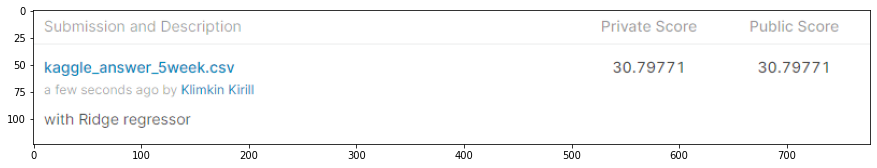

In [101]:
img = plt.imread('answer.png')
plt.figure(figsize=(15,7))
plt.imshow(img)
plt.show()